In [1]:
from math import cos, sin, sqrt, atan
from numpy import pi
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
from numba import njit,prange

In [2]:
R = 10.0
n = 1.5 #number of twists
width = 2 #on each side

In [3]:
@njit
def tl1(tm, x0, y0, z0, vx, vy, vz): #vx, vy
    stm = sin(tm)
    ctm = cos(tm)
    return (x0*stm - y0*ctm)/(vy*ctm - vx*stm)

@njit
def tl2(tm, x0, y0, z0, vx, vy, vz):#vy, vz
    ntm = n*tm
    sntm = sin(ntm)
    stm = sin(tm)
    cntm = cos(ntm)
    return ((y0 - R*stm)*sntm - z0*stm*cntm)/(vz*stm*cntm - vy*sntm)

@njit
def tl3(tm, x0, y0, z0, vx, vy, vz):#vx, vz
    ntm = n*tm
    sntm = sin(ntm)
    cntm = cos(ntm)
    ctm = cos(tm)
    return ((x0 - R*ctm)*sntm - z0*ctm*cntm)/(vz*ctm*cntm - vx*sntm)

In [4]:
@njit
def newton(guess, r0, v, verbose=False):
    tol = 1e-8
    ang_tol = 1e-3
    
    x0,y0,z0 = r0[0], r0[1], r0[2]
    vx,vy,vz = v[0], v[1], v[2]
    
    if vx != 0:
        for i in range(50): 
            sx = tl1(guess, x0, y0, z0, vx, vy, vz) - tl3(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl1(guess+tol, x0, y0, z0, vx, vy, vz) - tl1(guess-tol, x0, y0, z0, vx, vy, vz) - tl3(guess+tol, x0, y0, z0, vx, vy, vz) + tl3(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
            if ds == 0:
                break;
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vy != 0:
        for i in range(50): 
            sx = tl1(guess, x0, y0, z0, vx, vy, vz) - tl2(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl1(guess+tol, x0, y0, z0, vx, vy, vz) - tl1(guess-tol, x0, y0, z0, vx, vy, vz) - tl2(guess+tol, x0, y0, z0, vx, vy, vz) + tl2(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
            if ds == 0:
                break;
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vz != 0:
        for i in range(50): 
            sx = tl2(guess, x0, y0, z0, vx, vy, vz) - tl3(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl2(guess+tol, x0, y0, z0, vx, vy, vz) - tl2(guess-tol, x0, y0, z0, vx, vy, vz) - tl3(guess+tol, x0, y0, z0, vx, vy, vz) + tl3(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
            if ds == 0:
                break;
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    else:
        return None

In [5]:
def arc(r0, v, tl):
    x = r0[0] + v[0]*tl
    y = r0[1] + v[1]*tl
    if x == 0:
        if y > 0:
            return pi/2
        else:
            return 3*(pi/2)
    else:
        slope = y/x
        angle = atan(slope)
        if slope < 0:
            if y > 0:
                return angle + pi
            else:
                return 2*pi + angle
        elif slope ==0:
            if x > 0:
                return 0
            else:
                return pi
        else:
            if y > 0:
                return angle
            else:
                return angle+pi

# @njit
def find_angles(r0, v):
 
    splits = 7
    angles = set()
    round_deci = 14
    
    xy = xy_intersect(r0,v)
    if len(xy) == 0:
        return angles
    criticals = np.sort(xy)
    
    l = len(criticals)
    
    sections = []
    
    if l == 0:
        return None
    elif l == 1:
        a1 = arc(r0, v, criticals[0])
        return(set([a1]))
    elif l == 2:
        a1 = arc(r0, v, criticals[0])
        a2 = arc(r0, v, criticals[1])
        sections.append((a1, a2))
    else:
        a1 = arc(r0, v, criticals[0])
        a2 = arc(r0, v, criticals[1])
        a3 = arc(r0, v, criticals[2])
        a4 = arc(r0, v, criticals[3])
        sections.append((a1, a2))
        sections.append((a3, a4))
        
    #go in 0.005 radian increments
    for sec in sections:
#         print(sec)
        start = min(sec) - 0.0125
        finish = max(sec) + 0.015
        num_sections = int((finish - start) * 200)
        for i in range(num_sections):
            angle = start + (0.005 * i)
#             print(angle)
            newt = newton(angle, r0, v)
            newta = round(newt, round_deci) % round(2*pi, round_deci)
#             print(newta)
            angles.add(newta)
            
    
#     for i in range(splits):
#         angle = ((i+0.5)/splits) * 2 * pi
#         newt = newton(angle, r0, v)
#         a = round(newt, round_deci) % round(2*pi, round_deci)
#         angles.add(a)
        
    return angles

In [6]:
#quadratic equation to find the tl's that fit the outer and inner radii
# @njit
def xy_intersect(r0, v):
    q = r0[0]
    r = v[0]
    s = r0[1]
    t = v[1]
    
    O = R + width
    I = R - width
    
    c = q*q + s*s
    b = 2*(q*r + s*t)
    a = r*r + t*t
    
    c1 = c - O*O
    c2 = c - I*I
    
    deto = (b*b - 4*a*c1)
    deti = (b*b - 4*a*c2)
    
#     print(deto,deti)
    #this method can return exactly 0, 1, 2, or 4 points
    
    if a == 0: #vertical line, just checking if it's inside the taurus
        if c1 <= 0 and c2 >= 0:
            return np.array([0])
        else:
            return np.array([])
    
    if deto < 0: #does not intersect outer circle
        return np.array([])
    elif deto == 0: #tangent to outer circle only
        root = -b/(2*a)
        return np.array([root], dtype=np.float64)
    else:
        rootp = (-b + sqrt(deto))/(2*a)
        rootm = (-b - sqrt(deto))/(2*a)
        if deti <= 0: #crosses outer circle without crossing inner circle (can be tangent to inner)
            return np.array([rootp, rootm], dtype=np.float64)
        else:
            rootip = (-b + sqrt(deti))/(2*a)
            rootim = (-b - sqrt(deti))/(2*a)
            return np.array([rootp, rootm], dtype=np.float64)
#             return np.array([rootp, rootm, rootip, rootim], dtype=np.float64)
        

In [7]:
# @njit
def line_int(r0, v0, r1, v1):
    tol = 1e-5
    
    a = r0[0] - r1[0]
    b = r0[1] - r1[1]
    c = r0[2] - r1[2]
    d = v0[0]
    e = v0[1]
    f = v0[2]
    g = v1[0]
    h = v1[1]
    j = v1[2]
    
    # matrix is [[q,r],[s,t]] 
    # let * represent dot product
    # matrix is [[v0*v0, -v0*v1],[-v1*v0, v1*v1]]
    q = d*d + e*e + f*f
    r = -1*(d*g + e*h + f*j)
    s = r
    t = g*g + h*h + j*j
    
    u = -1*(a*d + b*e + c*f)
    v = (a*g + b*h + c*j)
    
    #do matrix inverse solve
    if(q*t - r*s) != 0: #make sure lines aren't parallel
        p = 1/(q*t - r*s)
        x = p*(t*u - s*v)
        y = p*(q*v - r*u)
        dist = sqrt((a + d*x - g*y)**2 + (b + e*x - h*y)**2 + (c + f*x - j*y)**2)
#         print(x, y, dist)
        if (dist <= tol and y <= width+tol and y >= -(width+tol)):
            return x
        else:
            return None
    else:
        #r1 = r0+v0t, #r1-r0 = v0t
        if (a!=0 and d==0) or (b!=0 and e==0) or (c!=0 and f==0):
            return None
        ts = set()
        if d!= 0:
            ts.add(-a/d)
        if e!= 0:
            ts.add(-b/e)
        if f!= 0:
            ts.add(-c/f)
        if len(ts) != 1:
            return None
        else:
            return ts[0]

In [8]:
# @njit
def intersect(r0, v):
    angles = find_angles(r0,v)
    
#     return (len(angles) > 0)
#     if len(angles) > 0:
#         print(angles)
    tls = []
    for a in angles:
        r1 = np.array([R*cos(a), R*sin(a), 0.0], dtype=np.float64)
        v1 = np.array([cos(a)*cos(a*n), sin(a)*cos(a*n), sin(a*n)], dtype=np.float64)
#         print(a, r1, v1)
        li = line_int(r0, v, r1, v1)
        if li != None:
            tls.append(li)
            
    if len(tls) != 0:
        return True
    return False

In [9]:
# @njit(parallel=True)
def main():
    im_size = 27 #units width
    ppu = 15 #pixels per unit
    size = im_size*ppu
    im_arr = np.zeros((size, size, 3), dtype = np.uint8)

    for i in range(size):
        if i%ppu == 0:
            print(i/ppu)
        for j in prange(size):
            z = (i/size - 0.5) * (im_size)
            y = (j/size - 0.5) * (im_size)
            x = 14

    #         v = np.asarray([0.0,0.0,-1.0], dtype=np.float64)
    #         r0 = np.asarray([x,y,z], dtype=np.float64)
            xv = (-1.0,0.0,0.0)
            xr0 = (x,y,z)
#             print(xr0)
            hit = intersect(xr0,xv)
            if hit:
                im_arr[i][j] = np.asarray([255,255,255], dtype=np.uint8)
            else:
                im_arr[i][j] = np.asarray([0,0,0], dtype=np.uint8)
    #         print(hit, x, y, z)
    
    return im_arr

In [10]:
r0 = np.array([10,0.0000,1.0])
v0 = np.array([0.0,0.0,-1.0])
r1 = np.array([10.1,0.0,0.0])
v1 = np.array([0.0,0.0,-1.0])
print(intersect(r0,v0))

True


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0


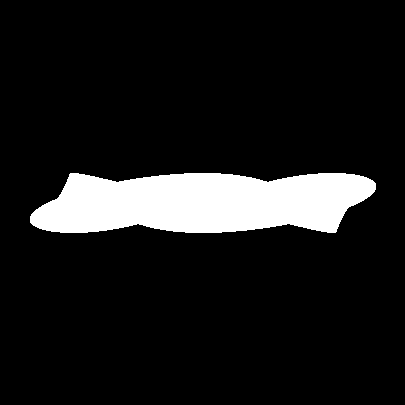

In [11]:
ia = main()
vf = Image.fromarray(ia)
vf.save("mob2.jpg")
display(vf)